In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
# from qecsim.graphtools import blossom5
from pymatching import Matching
import networkx as nx

## Error threshold calculation (star stabilizers)

In [29]:
Nrep_loss = 10 # number of iterations
Nrep_flip = 1000 # number of iterations
L_list = [6,8,10]
prob_l = 0.2 # loss rate
pz_list = np.linspace(0.06,0.1,5)
fail_prob_z = np.zeros((len(L_list),len(pz_list)))
loss_prob = np.zeros(len(L_list))

for i_L, r in enumerate(L_list):
    print("L= ", r)
    l = 2 # number of sublattice points (2 for toric code) or primal/dual
    r1 = r # number of columns
    r2 = r # number of rows
    
    def does_loss_percolate(loss_inds):
        Gy = nx.Graph()
        Gy.add_nodes_from(np.arange(r1*r2))
        Gx = nx.Graph()
        Gx.add_nodes_from(np.arange(r1*r2))


        for i2 in range(r2):
            for i1 in range(r1):
                ind1 = i2*r1+ i1
                ind2 = i2*r1 + ((i1+1)%r1)
                # cylinder along y
                if 2*ind1 in loss_inds:
                    Gy.add_edge(ind1,ind2)
                if ind1 +r1 < r1*r2 and 2*ind1+1 in loss_inds:
                    Gy.add_edge(ind1,ind1+r1)
                # cylinder along x
                ind2 = ((i2+1)%r2)*r1 + i1
                if 2*ind1+1 in loss_inds:
                    Gx.add_edge(ind1,ind2)
                if i1+1 < r1 and 2*ind1 in loss_inds:
                    Gx.add_edge(ind1,ind1+1)

        first_row = np.arange(r1)
        last_row = np.arange((r2-1)*r1,r2*r1)
        path_y = False
        for i_first in first_row:
            for i_last in last_row:
                if nx.has_path(Gy,i_first,i_last):
                    if (i_first - i_last )%r1 ==0: # or 2*i_last+1 in loss_inds
                        path_y = True
                        break
            if path_y:
                break

        first_col = np.arange(0,(r2-1)*r1+1,r1)
        last_col = np.arange(r1-1,r2*r1+1,r1)
        path_x = False
        for i_first in first_col:
            for i_last in last_col:
                if nx.has_path(Gx,i_first,i_last):
                    if  int(i_first/r1) == int(i_last/r1): # or 2*i_last in loss_inds
                        path_x = True
                        break
            if path_x:
                break

        for i in range(len(loss_inds)):
            ind1 = int(loss_inds[i]/2)
            if loss_inds[i] % 2 == 0 :
                ind2 = int(int(loss_inds[i]/2)/r1)*r1 + (((int(loss_inds[i]/2)%r1)+1)%r1)
                assert Gy.has_edge(ind1,ind2)
                ind2 = ind1 + 1
                if (int(loss_inds[i]/2)%r1)+1 < r1:
                    assert Gx.has_edge(ind1,ind2)     
            else:
                ind2 = ind1 + r1
                if ind2 < r1*r2:
                    assert Gy.has_edge(ind1,ind2)
                ind2 = ((int(int(loss_inds[i]/2)/r1)+1)%r2)*r1 + (int(loss_inds[i]/2)%r1)
                assert Gx.has_edge(ind1,ind2)
        return path_y,path_x

    def compute_eff_Sx(Sx,loss_inds,remain_inds):
        Sx_new = []
        inds_new = []
        Sx_old = np.copy(Sx)
        inds_old = list(range(r1*r2))
        for loss_index in loss_inds:
            st_ind = np.argwhere(Sx_old[:,loss_index]>0)
            st_ind = list(st_ind[:,0])
            if len(st_ind)==2:
                inds_new.append(st_ind)
                Stot = np.zeros(l*r1*r2)
                for i_remove in st_ind:
                    inds_old.remove(i_remove)
                    Stot += Sx_old[i_remove,:]
                Sx_new.append(list(Stot%2)) 
                Sx_old[st_ind,:] = 0
            elif len(st_ind)==1:
                st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
                inds_new[st_new_ind][:] += st_ind
                inds_old.remove(st_ind[0])
                Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
                Sx_old[st_ind,:] = 0
            else:
                st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
                if len(st_new_ind)>1:
                    st_new_ind = list(st_new_ind[:,0])
                    inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                    Stot = np.zeros(l*r1*r2)
                    for i_remove in st_new_ind:
                        Stot += np.array(Sx_new)[i_remove,:]        
                    Sx_new[st_new_ind[0]] = list(Stot%2)
                    del inds_new[st_new_ind[1]]
                    del Sx_new[st_new_ind[1]]
        Sx_new = np.array(Sx_new, dtype=int)

        for loss_index in loss_inds:
            st_ind = np.argwhere(Sx_old[:,loss_index]>0)
            st_new_ind = np.argwhere(Sx_new[:,loss_index]>0)
            assert len(st_ind)+len(st_new_ind)==0

        num_Sx_red = len(inds_new)+len(inds_old)
        Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
        Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
        if len(inds_new)>0:
            Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

        keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
        Sx_red = Sx_red[:,keep_cols]

        qubits_to_plot = remain_inds[keep_cols]
        return Sx_red, qubits_to_plot

    ##################
    def find_logical_ops(qubits_to_plot):
        num_qubits = len(qubits_to_plot)
        Gq_y = nx.Graph()
        for qubit in qubits_to_plot:
            if qubit % 2 == 0:
                if int(qubit/2)-r1 >= 0:
                    Gq_y.add_edge(int(qubit/2),int(qubit/2)-r1)
            else:
                q2 = int(int(qubit/2)/r1)*r1 + ((int(qubit/2)%r1-1)%r1)
                Gq_y.add_edge(int(qubit/2),q2)

        first_row = np.arange(r1)
        last_row = np.arange((r2-1)*r1,r2*r1)
        path_y = False
        for i_first in first_row:
            if i_first in Gq_y.nodes():
                for i_last in last_row:
                    if i_last in Gq_y.nodes():
                        if nx.has_path(Gq_y,i_first,i_last):
                            if (i_first - i_last )%r1 ==0 and (2*i_first in qubits_to_plot):
                                path_y = True
                                path_y_vals = nx.shortest_path(Gq_y,i_first,i_last)
                                break
            if path_y:
                break

        Gq_x = nx.Graph()
        for qubit in qubits_to_plot:
            if qubit % 2 == 1:
                if (int(qubit/2)%r1)-1 >= 0:
                    Gq_x.add_edge(int(qubit/2),int(qubit/2)-1)
            else:
                q2 = ((int(int(qubit/2)/r1)-1)%r2)*r1 + (int(qubit/2)%r1)
                Gq_x.add_edge(int(qubit/2),q2)

        first_col = np.arange(0,(r2-1)*r1+1,r1)
        last_col = np.arange(r1-1,r2*r1+1,r1)
        path_x = False
        for i_first in first_col:
            if i_first in Gq_x.nodes():
                for i_last in last_col:
                    if i_last in Gq_x.nodes():
                        if nx.has_path(Gq_x,i_first,i_last):
                            if int(i_first/r1) == int(i_last/r1) and (2*i_first+1 in qubits_to_plot):
                                path_x = True
                                path_x_vals = nx.shortest_path(Gq_x,i_first,i_last)
                                break
            if path_x:
                break
        # if path_x and path_y:
        logical_y = np.zeros(l*r1*r2)
        logical_y[2*path_y_vals[0]] = 1
        for i_v, v1 in enumerate(path_y_vals):
            if i_v < len(path_y_vals)-1:
                v2 = path_y_vals[i_v+1]
                if np.abs(v2-v1)==1:
                    logical_y[2*max([v1,v2])+1] = 1
                elif np.abs(v2-v1)==r1:
                    logical_y[2*max([v1,v2])] = 1
                else:
                    logical_y[2*min([v1,v2])+1] = 1

        logical_x = np.zeros(l*r1*r2)
        logical_x[2*path_x_vals[0]+1] = 1
        for i_v, v1 in enumerate(path_x_vals):
            if i_v < len(path_x_vals)-1:
                v2 = path_x_vals[i_v+1]
                if np.abs(v2-v1)==1:
                    logical_x[2*max([v1,v2])+1] = 1
                elif np.abs(v2-v1)==r1:
                    logical_x[2*max([v1,v2])] = 1
                else:
                    logical_x[2*min([v1,v2])] = 1
        return logical_x, logical_y
        # return path_x and path_y, logical_x, logical_y
        # else:
        #     return False, 0, 0

    def netx_Sx(Sx_red,qubits_to_plot):
        overlap = Sx_red.T@Sx_red
        inds_to_keep = list(range(np.size(Sx_red,1)))
        nl = []
        counter = 0
        i = 0 
        while counter < np.size(Sx_red,1):
            edge = inds_to_keep[i]
            ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
            if len(ovlp_inds)>0:
                # print("edge= ", edge)
                for j in ovlp_inds[::-1,0]:
                    # print(inds_to_keep[i+1+j])
                    inds_to_keep.remove(inds_to_keep[i+1+j])
                # print(inds_to_keep)
                counter += (len(ovlp_inds)+1)
                nl.append(len(ovlp_inds)+1)
            else:
                counter += 1
                nl.append(1)
            i += 1

        Sx_red_netx = Sx_red[:,inds_to_keep]
        # remain_qubits = remain_inds[keep_cols[inds_to_keep]]
        remain_qubits = qubits_to_plot[inds_to_keep]
        nl = np.array(nl)
        return Sx_red_netx,remain_qubits, nl

    ##################
    # star stabilzers
    Sx = np.zeros((r1*r2,l*r1*r2),dtype=int)
    for i_y in range(r2):
        for i_x in range(r1):
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
            Sx[i_y*r1 + i_x, 2*(((i_y-1)%r1)*r1+i_x)+1] = 1

    for i_loss in range(Nrep_loss):

       ## loss error
        error_loss = np.random.rand(l*r1*r2) 
        loss_inds = np.argwhere(error_loss < prob_l)[:,0]
        remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
        percolate_y, percolate_x = does_loss_percolate(loss_inds) 
        loss_percolate = (percolate_x or percolate_y)
        if loss_percolate:
            # fail_prob_z[i_L,i_p] +=  1
            loss_prob[i_L] +=  1
            continue
        error_loss[loss_inds] = 1
        error_loss[remain_inds] = 0

        Sx_red, qubits_to_plot = compute_eff_Sx(Sx,loss_inds,remain_inds)

        lost_qubits = np.array(list(set(np.arange(l*r1*r2)) - set(qubits_to_plot)))
        percolate_y, percolate_x = does_loss_percolate(lost_qubits)
        loss_percolate = (percolate_x or percolate_y)
        if loss_percolate:
            # fail_prob_z[i_L,i_p] +=  1
            loss_prob[i_L] +=  1
            continue

        logical_x, logical_y = find_logical_ops(qubits_to_plot)
        # logic_exist, logical_x, logical_y = find_logical_ops(qubits_to_plot)
        # if not logic_exist:
        #     fail_prob_z[i_L,i_p] +=  1
        #     print("how?")
        #     continue

        Sx_red_netx, remain_qubits, nl = netx_Sx(Sx_red,qubits_to_plot)
        num_edge = len(remain_qubits) 
        ################

        for i_p, prob_z in enumerate(pz_list):
            for i_n in range(Nrep_flip):

                pl = (1-(1-2*prob_z)**nl)/2
                error_table = np.random.rand(num_edge) < pl
                zflip_inds = np.argwhere(error_table == True)[:,0]
                no_zflip_inds = np.argwhere(error_table == False)[:,0]
                error_z = np.zeros(num_edge,dtype=int)
                error_z[zflip_inds] = 1
                error_z[no_zflip_inds] = 0

                if num_edge > 1:
                    m = Matching(Sx_red_netx,spacelike_weights=np.log((1-pl)/pl))
                else:
                    print("how?")
                    fail_prob_z[i_L,i_p] +=  1
                    continue

                # find syndrome
                syndrome_x = Sx_red_netx@error_z % 2
                synd_x_inds = np.argwhere(syndrome_x > 0)
                if len(synd_x_inds)>0:
                    rec2 = m.decode(syndrome_x)

                    error_rec = (rec2 + error_z )%2
                    s_h = np.dot( error_rec , logical_x[remain_qubits].T) %2 
                    s_v = np.dot( error_rec, logical_y[remain_qubits].T) %2 

                    assert np.sum(np.dot( error_rec , Sx_red_netx.T) % 2) == 0

                    ###########
                    if s_h + s_v  > 0:
                        fail_prob_z[i_L,i_p] +=  1

print("Done!")

L=  6
L=  8
L=  10
Done!


In [31]:
print(loss_prob)

[0. 0. 0.]


[0. 0. 0.]


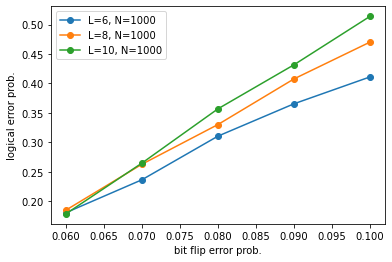

In [32]:
print(loss_prob/Nrep_loss)
for i_L, L in enumerate(L_list):
    failure_ratio = fail_prob_z[i_L,:].T/(Nrep_flip*(Nrep_loss-loss_prob[i_L]))
    plt.plot(pz_list, failure_ratio, "o-", label="L=%d, N=%d" % (L,Nrep))
    # de = np.std(fail_prob_z[i_L,:]/Nrep)/np.sqrt(Nrep-1)
    # plt.errorbar(pz_list,fail_prob_z[i_L,:].T/Nrep,de, label="L=%d, N=%d" % (L,Nrep))

# plt.plot(px_list,fail_prob_x.T/Nrep,"x-")
plt.xlabel("bit flip error prob.")
plt.ylabel("logical error prob.")
plt.legend()
plt.show()

## checking logical operators graphically

In [3]:
# square lattice
l = 2
r1 = 4
r2 = r1

 # loss error
prob_l = 0.2 # loss error probability
error_loss = np.random.rand(l*r1*r2) 
loss_inds = np.argwhere(error_loss < prob_l)[:,0]
remain_inds = np.argwhere(error_loss >= prob_l)[:,0]

def does_loss_percolate(loss_inds):
    Gy = nx.Graph()
    Gy.add_nodes_from(np.arange(r1*r2))
    Gx = nx.Graph()
    Gx.add_nodes_from(np.arange(r1*r2))


    for i2 in range(r2):
        for i1 in range(r1):
            ind1 = i2*r1+ i1
            ind2 = i2*r1 + ((i1+1)%r1)
            # cylinder along y
            if 2*ind1 in loss_inds:
                Gy.add_edge(ind1,ind2)
            if ind1 +r1 < r1*r2 and 2*ind1+1 in loss_inds:
                Gy.add_edge(ind1,ind1+r1)
            # cylinder along x
            ind2 = ((i2+1)%r2)*r1 + i1
            if 2*ind1+1 in loss_inds:
                Gx.add_edge(ind1,ind2)
            if i1+1 < r1 and 2*ind1 in loss_inds:
                Gx.add_edge(ind1,ind1+1)

    first_row = np.arange(r1)
    last_row = np.arange((r2-1)*r1,r2*r1)
    path_y = False
    for i_first in first_row:
        for i_last in last_row:
            if nx.has_path(Gy,i_first,i_last):
                if (i_first - i_last )%r1 ==0: # or 2*i_last+1 in loss_inds
                    path_y = True
                    break
        if path_y:
            break

    first_col = np.arange(0,(r2-1)*r1+1,r1)
    last_col = np.arange(r1-1,r2*r1+1,r1)
    path_x = False
    for i_first in first_col:
        for i_last in last_col:
            if nx.has_path(Gx,i_first,i_last):
                if  int(i_first/r1) == int(i_last/r1): # or 2*i_last in loss_inds
                    path_x = True
                    break
        if path_x:
            break
    for i in range(len(loss_inds)):
        ind1 = int(loss_inds[i]/2)
        if loss_inds[i] % 2 == 0 :
            ind2 = int(int(loss_inds[i]/2)/r1)*r1 + (((int(loss_inds[i]/2)%r1)+1)%r1)
            assert Gy.has_edge(ind1,ind2)
            ind2 = ind1 + 1
            if (int(loss_inds[i]/2)%r1)+1 < r1:
                assert Gx.has_edge(ind1,ind2)     
        else:
            ind2 = ind1 + r1
            if ind2 < r1*r2:
                assert Gy.has_edge(ind1,ind2)
            ind2 = ((int(int(loss_inds[i]/2)/r1)+1)%r2)*r1 + (int(loss_inds[i]/2)%r1)
            assert Gx.has_edge(ind1,ind2)

    return path_y,path_x

print(does_loss_percolate(loss_inds))

(False, False)


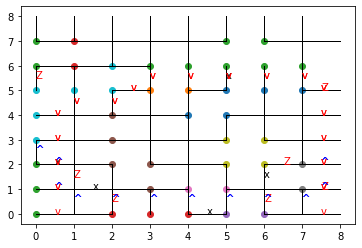

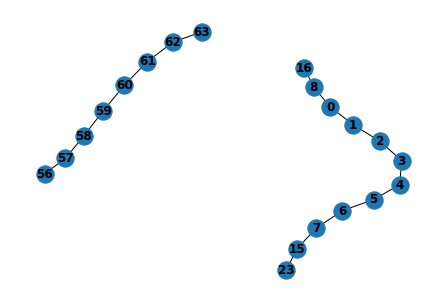

660
1


In [26]:
l = 2
r1 = 8
r2 = r1

# star stabilzers
Sx = np.zeros((r1*r2,l*r1*r2),dtype=int)
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r1)*r1+i_x)+1] = 1

# # loss error
prob_l = 0.2 # loss error probability
fail = 0
for iter in range(1000):
    # print(iter, end="\r")
    percolate_x = True
    percolate_y = True

    while (percolate_x or percolate_y):
        error_loss = np.random.rand(l*r1*r2) 
        loss_inds = np.argwhere(error_loss < prob_l)[:,0]
        remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
        percolate_y, percolate_x = does_loss_percolate(loss_inds) 
        error_loss[loss_inds] = 1
        error_loss[remain_inds] = 0


        Sx_new = []
        inds_new = []
        Sx_old = np.copy(Sx)
        inds_old = list(range(r1*r2))
        for loss_index in loss_inds:
            st_ind = np.argwhere(Sx_old[:,loss_index]>0)
            st_ind = list(st_ind[:,0])
            if len(st_ind)==2:
                inds_new.append(st_ind)
                Stot = np.zeros(l*r1*r2)
                for i_remove in st_ind:
                    inds_old.remove(i_remove)
                    Stot += Sx_old[i_remove,:]
                Sx_new.append(list(Stot%2)) 
                Sx_old[st_ind,:] = 0
            elif len(st_ind)==1:
                st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
                inds_new[st_new_ind][:] += st_ind
                inds_old.remove(st_ind[0])
                Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
                Sx_old[st_ind,:] = 0
            else:
                st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
                if len(st_new_ind)>1:
                    st_new_ind = list(st_new_ind[:,0])
                    inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                    Stot = np.zeros(l*r1*r2)
                    for i_remove in st_new_ind:
                        Stot += np.array(Sx_new)[i_remove,:]        
                    Sx_new[st_new_ind[0]] = list(Stot%2)
                    del inds_new[st_new_ind[1]]
                    del Sx_new[st_new_ind[1]]
        Sx_new = np.array(Sx_new, dtype=int)

        for loss_index in loss_inds:
            st_ind = np.argwhere(Sx_old[:,loss_index]>0)
            st_new_ind = np.argwhere(Sx_new[:,loss_index]>0)
            assert len(st_ind)+len(st_new_ind)==0

        color = 1
        plt.figure(1)
        plt.cla()
        for s_plaq in inds_new:
            color += 1
            for latt_pos in s_plaq:
                plt.plot((latt_pos%r1),int(latt_pos/r1),"o",color="C%d" % (color))

        num_Sx_red = len(inds_new)+len(inds_old)
        Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
        # print(np.shape(Sx_red[0:len(inds_old),:]),np.shape(Sx_old[np.ix_(inds_old,remain_inds)]))
        Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
        if len(inds_new)>0:
            Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

        keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
        Sx_red = Sx_red[:,keep_cols]

        qubits_to_plot = remain_inds[keep_cols]
        lost_qubits = np.array(list(set(np.arange(l*r1*r2)) - set(qubits_to_plot)))
        percolate_y, percolate_x = does_loss_percolate(lost_qubits)

    plt.figure(1)
    for i in range(len(qubits_to_plot)):
        latt_pos = int(qubits_to_plot[i]/2)
        if qubits_to_plot[i] % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) 
            plt.plot([rx,rx+1],[ry,ry],color="k",linewidth=1)
        else:
            ry = int(latt_pos/r1)  
            rx = (latt_pos%r1)   
            plt.plot([rx,rx],[ry,ry+1],color="k",linewidth=1)


    num_qubits = len(qubits_to_plot)

    overlap = Sx_red.T@Sx_red
    inds_to_keep = list(range(np.size(Sx_red,1)))
    nl = []
    counter = 0
    i = 0 
    while counter < np.size(Sx_red,1):
        edge = inds_to_keep[i]
        ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
        if len(ovlp_inds)>0:
            # print("edge= ", edge)
            for j in ovlp_inds[::-1,0]:
                # print(inds_to_keep[i+1+j])
                inds_to_keep.remove(inds_to_keep[i+1+j])
            # print(inds_to_keep)
            counter += (len(ovlp_inds)+1)
            nl.append(len(ovlp_inds)+1)
        else:
            counter += 1
            nl.append(1)
        i += 1

    Sx_red_netx = Sx_red[:,inds_to_keep]
    remain_qubits = remain_inds[keep_cols[inds_to_keep]]
    num_edge = len(remain_qubits) #np.size(Sx_red_netx,1)

    nl = np.array(nl)
    num_qubits = len(qubits_to_plot)
    ################# bit flip error  ##################
    prob_z = 0.1 # error probability
    pl = (1-(1-2*prob_z)**nl)/2
    error_table = np.random.rand(num_edge) < pl
    zflip_inds = np.argwhere(error_table == True)[:,0]
    no_zflip_inds = np.argwhere(error_table == False)[:,0]
    error_z = np.zeros(num_edge,dtype=int)
    error_z[zflip_inds] = 1
    error_z[no_zflip_inds] = 0

    plt.figure(1)
    for i in range(len(zflip_inds)):
        latt_pos = int(remain_qubits[zflip_inds[i]]/2)
        if remain_qubits[zflip_inds[i]] % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) + 0.5   
        else:
            ry = int(latt_pos/r1)  + 0.5 #+0.1
            rx = (latt_pos%r1)   

        plt.text(rx,ry,"Z",color="r")

    if num_edge > 1:
        # print("logical qubits: ", num_edge-2*Sx_red_netx.shape[0]+2)
        m = Matching(Sx_red_netx,spacelike_weights=np.log((1-pl)/pl))

    # find syndrome
    syndrome_x = Sx_red_netx@error_z % 2
    synd_x_inds = np.argwhere(syndrome_x > 0)
    # print(synd_x_inds)
    if len(synd_x_inds)>0:
        rec2 = m.decode(syndrome_x)
        rec2_inds = np.argwhere(rec2 > 0)[:,0]
        # print(rec2_inds[:,0])
        plt.figure(1)
        for i in range(len(rec2_inds)):
            latt_pos = int(remain_qubits[rec2_inds[i]]/2)
            if remain_qubits[rec2_inds[i]] % 2 == 0 :
                ry = int(latt_pos/r1) 
                rx = (latt_pos%r1) + 0.5   
            else:
                ry = int(latt_pos/r1)  + 0.5 #+0.1
                rx = (latt_pos%r1)   

            plt.text(rx,ry,"x",color="k")
    else:
        continue
    
    #################################
    Gq_x = nx.Graph()
    for qubit in qubits_to_plot:
        if qubit % 2 == 1:
            if (int(qubit/2)%r1)-1 >= 0:
                Gq_x.add_edge(int(qubit/2),int(qubit/2)-1)
        else:
            q2 = ((int(int(qubit/2)/r1)-1)%r2)*r1 + (int(qubit/2)%r1)
            Gq_x.add_edge(int(qubit/2),q2)

    first_col = np.arange(0,(r2-1)*r1+1,r1)
    last_col = np.arange(r1-1,r2*r1+1,r1)
    path_x = False
    for i_first in first_col:
        if i_first in Gq_x.nodes():
            for i_last in last_col:
                if i_last in Gq_x.nodes():
                    if nx.has_path(Gq_x,i_first,i_last):
                        if int(i_first/r1) == int(i_last/r1) and (2*i_first+1 in qubits_to_plot):
    #                                     print(i_first,i_last)
                            path_x = True
                            path_x_vals = nx.shortest_path(Gq_x,i_first,i_last)
    #                                     print(path_x_vals)
                            break
        if path_x:
            break

    logical_x = np.zeros(l*r1*r2)
    logical_x[2*path_x_vals[0]+1] = 1
    for i_v, v1 in enumerate(path_x_vals):
        if i_v < len(path_x_vals)-1:
            v2 = path_x_vals[i_v+1]
            if np.abs(v2-v1)==1:
                logical_x[2*max([v1,v2])+1] = 1
            elif np.abs(v2-v1)==r1:
                logical_x[2*max([v1,v2])] = 1
            else:
                logical_x[2*min([v1,v2])] = 1

    inds_logic_h = np.argwhere(logical_x[qubits_to_plot] > 0 )[:,0]
    # for link in qubits_to_plot[inds_logic_h]:
    #     latt_pos = int(link/2)
    #     if link % 2 == 0 :
    #         ry = int(latt_pos/r1) 
    #         rx = (latt_pos%r1) + 0.5   
    #     else:
    #         ry = int(latt_pos/r1)  + 0.5 #+0.1
    #         rx = (latt_pos%r1)   
    #     plt.text(rx,ry,"o",color="g")

    Gq_y = nx.Graph()
    for qubit in qubits_to_plot:
        if qubit % 2 == 0:
            if int(qubit/2)-r1 >= 0:
                Gq_y.add_edge(int(qubit/2),int(qubit/2)-r1)
        else:
            q2 = int(int(qubit/2)/r1)*r1 + ((int(qubit/2)%r1-1)%r1)
            Gq_y.add_edge(int(qubit/2),q2)

    first_row = np.arange(r1)
    last_row = np.arange((r2-1)*r1,r2*r1)
    path_y = False
    for i_first in first_row:
        if i_first in Gq_y.nodes():
            for i_last in last_row:
                if i_last in Gq_y.nodes():
                    if nx.has_path(Gq_y,i_first,i_last):
                        if (i_first - i_last )%r1 ==0 and (2*i_first in qubits_to_plot):
                            path_y = True
                            path_y_vals = nx.shortest_path(Gq_y,i_first,i_last)
                            break
        if path_y:
            break

    logical_y = np.zeros(l*r1*r2)
    logical_y[2*path_y_vals[0]] = 1
    for i_v, v1 in enumerate(path_y_vals):
        if i_v < len(path_y_vals)-1:
            v2 = path_y_vals[i_v+1]
            if np.abs(v2-v1)==1:
                logical_y[2*max([v1,v2])+1] = 1
            elif np.abs(v2-v1)==r1:
                logical_y[2*max([v1,v2])] = 1
            else:
                logical_y[2*min([v1,v2])+1] = 1

    inds_logic_h = np.argwhere(logical_y[qubits_to_plot] > 0 )[:,0]
    # for link in qubits_to_plot[inds_logic_h]:
    #     latt_pos = int(link/2)
    #     if link % 2 == 0 :
    #         ry = int(latt_pos/r1) 
    #         rx = (latt_pos%r1) + 0.5   
    #     else:
    #         ry = int(latt_pos/r1)  + 0.5 #+0.1
    #         rx = (latt_pos%r1)   
    #     plt.text(rx,ry,"v",color="b")

    ################
    ###############
    
    def horizontal_logic(i2):
        # i2 = int(r2/2)
        i_h = (i2*r1+np.arange(r1))
        logical_h = np.zeros(l*r1*r2)
        i_new_used = np.zeros(len(inds_new),dtype = bool)
        for h_pos in i_h:
            if h_pos in inds_old:
                logical_h += Sx[h_pos,:] 
            else:   
                for i_new in range(len(inds_new)):
                    if h_pos in inds_new[i_new] and i_new_used[i_new]==False:
                        logical_h += Sx_new[i_new,:] 
                        i_new_used[i_new] = True

        logical_h = (logical_h% 2)
        ind_logic = np.argwhere(logical_h>0)[:,0]

        return logical_h
    logic_graph = []
    for i2 in range(r2):
    # i2 = 2#int(r2/2)
        logical_h = horizontal_logic(i2)
        inds_logic_h = np.argwhere(logical_h[qubits_to_plot] > 0 )[:,0]
        Gq_x = nx.Graph()
        for qubit in qubits_to_plot[inds_logic_h]:
            if qubit % 2 == 1:
                if (int(qubit/2)%r1)-1 >= 0:
                    Gq_x.add_edge(int(qubit/2),int(qubit/2)-1)
            else:
                q2 = ((int(int(qubit/2)/r1)-1)%r2)*r1 + (int(qubit/2)%r1)
                Gq_x.add_edge(int(qubit/2),q2)


        components = [Gq_x.subgraph(c).copy() for c in nx.connected_components(Gq_x)]
    #     print(components[0].nodes())
    #     print(len(components))
        if len(components)==2:
            logic_graph = components[0].nodes()
            break
    if len(components)!=2:
        print("could not find horz logical op")
        
    # for link in qubits_to_plot[inds_logic_h]:
    #     latt_pos = int(link/2)
    #     if link % 2 == 0 :
    #         ry = int(latt_pos/r1) 
    #         rx = (latt_pos%r1) + 0.5   
    #     else:
    #         ry = int(latt_pos/r1)  + 0.5 #+0.1
    #         rx = (latt_pos%r1)   
    #     plt.text(rx,ry,"v",color="r")    
    
    logical_qs = []
    for vertex in logic_graph:
        if 2*vertex in qubits_to_plot[inds_logic_h]:
            logical_qs.append(2*vertex)
        if 2*vertex+1 in qubits_to_plot[inds_logic_h]:
            logical_qs.append(2*vertex+1)
        v2 = int(vertex/r1)*r1 + ((vertex%r1)+1)%r1
        if 2*v2+1 in qubits_to_plot[inds_logic_h]:
            logical_qs.append(2*v2+1)
        v2 = ((int(vertex/r1)+1)%r2)*r1 + (vertex%r1)
        if 2*v2 in qubits_to_plot[inds_logic_h]:
            logical_qs.append(2*v2)

    logical2_x = np.zeros(l*r1*r2)
    logical2_x[logical_qs] = 1

    for link in logical_qs:
        latt_pos = int(link/2)
        if link % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) + 0.5   
        else:
            ry = int(latt_pos/r1)  + 0.5 #+0.1
            rx = (latt_pos%r1)   
        plt.text(rx,ry,"^",color="b")      

    ################
    def vertical_logic(i1):
        i_v = (i1+r1*np.arange(r2))
        logical_v = np.zeros(l*r1*r2)
        i_new_used = np.zeros(len(inds_new),dtype = bool)
        for v_pos in i_v:
            if v_pos in inds_old:
                logical_v += Sx[v_pos,:] 
            else:   
                for i_new in range(len(inds_new)):
                    if v_pos in inds_new[i_new] and i_new_used[i_new]==False:
                        logical_v += Sx_new[i_new,:] 
                        i_new_used[i_new] = True

        logical_v = (logical_v% 2)
        ind_logic = np.argwhere(logical_v>0)[:,0]
        used_inds = np.argwhere(i_new_used==True)[:,0]
  
        return logical_v
    logic_graph = []
    for i1 in range(r1):
    # for i1 in [1]:
        logical_v = vertical_logic(i1)
        inds_logic_v = np.argwhere(logical_v[qubits_to_plot] > 0 )[:,0]
        Gq_y = nx.Graph()
        for qubit in qubits_to_plot[inds_logic_v]:
            if qubit % 2 == 0:
                if int(qubit/2)-r1 >= 0:
                    Gq_y.add_edge(int(qubit/2),int(qubit/2)-r1)
            else:
                q2 = int(int(qubit/2)/r1)*r1 + ((int(qubit/2)%r1-1)%r1)
                Gq_y.add_edge(int(qubit/2),q2)
      
        components = [Gq_y.subgraph(c).copy() for c in nx.connected_components(Gq_y)]
        # print(components[0].nodes())
        # print(len(components))
        if len(components)==2:
            logic_graph = components[0].nodes()
            break
    if len(components)!=2:
        print("could not find vert logical op")
    # for link in qubits_to_plot[inds_logic_v]:
    #     latt_pos = int(link/2)
    #     if link % 2 == 0 :
    #         ry = int(latt_pos/r1) 
    #         rx = (latt_pos%r1) + 0.5   
    #     else:
    #         ry = int(latt_pos/r1)  + 0.5 #+0.1
    #         rx = (latt_pos%r1)   
    #     plt.text(rx,ry,"v",color="b")

    logical_qs = []
    for vertex in logic_graph:
        if 2*vertex in qubits_to_plot[inds_logic_v]:
            logical_qs.append(2*vertex)
        if 2*vertex+1 in qubits_to_plot[inds_logic_v]:
            logical_qs.append(2*vertex+1)
        v2 = int(vertex/r1)*r1 + ((vertex%r1)+1)%r1
        if 2*v2+1 in qubits_to_plot[inds_logic_v]:
            logical_qs.append(2*v2+1)
        v2 = ((int(vertex/r1)+1)%r2)*r1 + (vertex%r1)
        if 2*v2 in qubits_to_plot[inds_logic_v]:
            logical_qs.append(2*v2)

    logical2_y = np.zeros(l*r1*r2)
    logical2_y[logical_qs] = 1

    for link in logical_qs:
        latt_pos = int(link/2)
        if link % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) + 0.5   
        else:
            ry = int(latt_pos/r1)  + 0.5 #+0.1
            rx = (latt_pos%r1)   
        plt.text(rx,ry,"v",color="r")      

    ################
    ################
    plt.xticks(np.arange(0,r1+1.))
    plt.yticks(np.arange(0,r2+1.))

    # if not (path_x and path_y):
    # plt.show()
        
    # nx.draw(Gq_y, with_labels=True, font_weight='bold')
    # plt.show()
    error_rec = (rec2 + error_z )%2
    s1x = np.dot( error_rec , logical_x[remain_qubits].T) %2 
    s2x = np.dot( error_rec , logical2_x[remain_qubits].T) %2 
    s1y = np.dot( error_rec , logical_y[remain_qubits].T) %2 
    s2y = np.dot( error_rec , logical2_y[remain_qubits].T) %2 

    if (s1x+s1y > 0 and s2x+s2y == 0) or (s1x+s1y== 0 and s2x+s2y > 0):
        fail += 1
        print()
        plt.show()
        nx.draw(Gq_x, with_labels=True, font_weight='bold')
        plt.show()
        break
    
print(iter)
print(fail)

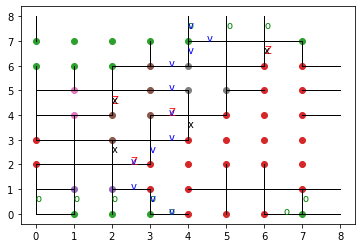

0.0 0.0


In [36]:
l = 2
r1 = 8
r2 = r1

# star stabilzers
Sx = np.zeros((r1*r2,l*r1*r2),dtype=int)
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r1)*r1+i_x)+1] = 1

# # loss error
prob_l = 0.4 # loss error probability
percolate_x = True
percolate_y = True

while (percolate_x or percolate_y):
    error_loss = np.random.rand(l*r1*r2) 
    loss_inds = np.argwhere(error_loss < prob_l)[:,0]
    remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
    percolate_y, percolate_x = does_loss_percolate(loss_inds) 
    error_loss[loss_inds] = 1
    error_loss[remain_inds] = 0

    Sx_new = []
    inds_new = []
    Sx_old = np.copy(Sx)
    inds_old = list(range(r1*r2))
    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_ind = list(st_ind[:,0])
        if len(st_ind)==2:
            inds_new.append(st_ind)
            Stot = np.zeros(l*r1*r2)
            for i_remove in st_ind:
                inds_old.remove(i_remove)
                Stot += Sx_old[i_remove,:]
            Sx_new.append(list(Stot%2)) 
            Sx_old[st_ind,:] = 0
        elif len(st_ind)==1:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
            inds_new[st_new_ind][:] += st_ind
            inds_old.remove(st_ind[0])
            Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
            Sx_old[st_ind,:] = 0
        else:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
            if len(st_new_ind)>1:
                st_new_ind = list(st_new_ind[:,0])
                inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                Stot = np.zeros(l*r1*r2)
                for i_remove in st_new_ind:
                    Stot += np.array(Sx_new)[i_remove,:]        
                Sx_new[st_new_ind[0]] = list(Stot%2)
                del inds_new[st_new_ind[1]]
                del Sx_new[st_new_ind[1]]
    Sx_new = np.array(Sx_new, dtype=int)

    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_new_ind = np.argwhere(Sx_new[:,loss_index]>0)
        assert len(st_ind)+len(st_new_ind)==0

    color = 1
    plt.figure(1)
    plt.cla()
    for s_plaq in inds_new:
        color += 1
        for latt_pos in s_plaq:
            plt.plot((latt_pos%r1),int(latt_pos/r1),"o",color="C%d" % (color))

    num_Sx_red = len(inds_new)+len(inds_old)
    Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
    # print(np.shape(Sx_red[0:len(inds_old),:]),np.shape(Sx_old[np.ix_(inds_old,remain_inds)]))
    Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
    if len(inds_new)>0:
        Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

    keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
    Sx_red = Sx_red[:,keep_cols]

    qubits_to_plot = remain_inds[keep_cols]
    lost_qubits = np.array(list(set(np.arange(l*r1*r2)) - set(qubits_to_plot)))
    percolate_y, percolate_x = does_loss_percolate(lost_qubits)

plt.figure(1)
for i in range(len(qubits_to_plot)):
    latt_pos = int(qubits_to_plot[i]/2)
    if qubits_to_plot[i] % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) 
        plt.plot([rx,rx+1],[ry,ry],color="k",linewidth=1)
    else:
        ry = int(latt_pos/r1)  
        rx = (latt_pos%r1)   
        plt.plot([rx,rx],[ry,ry+1],color="k",linewidth=1)


num_qubits = len(qubits_to_plot)

overlap = Sx_red.T@Sx_red
inds_to_keep = list(range(np.size(Sx_red,1)))
nl = []
counter = 0
i = 0 
while counter < np.size(Sx_red,1):
    edge = inds_to_keep[i]
    ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
    if len(ovlp_inds)>0:
        # print("edge= ", edge)
        for j in ovlp_inds[::-1,0]:
            # print(inds_to_keep[i+1+j])
            inds_to_keep.remove(inds_to_keep[i+1+j])
        # print(inds_to_keep)
        counter += (len(ovlp_inds)+1)
        nl.append(len(ovlp_inds)+1)
    else:
        counter += 1
        nl.append(1)
    i += 1

Sx_red_netx = Sx_red[:,inds_to_keep]
remain_qubits = remain_inds[keep_cols[inds_to_keep]]
num_edge = len(remain_qubits) #np.size(Sx_red_netx,1)

nl = np.array(nl)
num_qubits = len(qubits_to_plot)
################# bit flip error  ##################
prob_z = 0.04 # error probability
pl = (1-(1-2*prob_z)**nl)/2
error_table = np.random.rand(num_edge) < pl
zflip_inds = np.argwhere(error_table == True)[:,0]
no_zflip_inds = np.argwhere(error_table == False)[:,0]
error_z = np.zeros(num_edge,dtype=int)
error_z[zflip_inds] = 1
error_z[no_zflip_inds] = 0

plt.figure(1)
for i in range(len(zflip_inds)):
    latt_pos = int(remain_qubits[zflip_inds[i]]/2)
    if remain_qubits[zflip_inds[i]] % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) + 0.5   
    else:
        ry = int(latt_pos/r1)  + 0.5 #+0.1
        rx = (latt_pos%r1)   

    plt.text(rx,ry,"Z",color="r")

if num_edge > 1:
    # print("logical qubits: ", num_edge-2*Sx_red_netx.shape[0]+2)
    m = Matching(Sx_red_netx,spacelike_weights=np.log((1-pl)/pl))

# find syndrome
syndrome_x = Sx_red_netx@error_z % 2
synd_x_inds = np.argwhere(syndrome_x > 0)
# print(synd_x_inds)
if len(synd_x_inds)>0:
    rec2 = m.decode(syndrome_x)
    rec2_inds = np.argwhere(rec2 > 0)[:,0]
    # print(rec2_inds[:,0])
    plt.figure(1)
    for i in range(len(rec2_inds)):
        latt_pos = int(remain_qubits[rec2_inds[i]]/2)
        if remain_qubits[rec2_inds[i]] % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) + 0.5   
        else:
            ry = int(latt_pos/r1)  + 0.5 #+0.1
            rx = (latt_pos%r1)   

        plt.text(rx,ry,"x",color="k")

#################################
Gq_x = nx.Graph()
for qubit in qubits_to_plot:
    if qubit % 2 == 1:
        if (int(qubit/2)%r1)-1 >= 0:
            Gq_x.add_edge(int(qubit/2),int(qubit/2)-1)
    else:
        q2 = ((int(int(qubit/2)/r1)-1)%r2)*r1 + (int(qubit/2)%r1)
        Gq_x.add_edge(int(qubit/2),q2)

first_col = np.arange(0,(r2-1)*r1+1,r1)
last_col = np.arange(r1-1,r2*r1+1,r1)
path_x = False
for i_first in first_col:
    if i_first in Gq_x.nodes():
        for i_last in last_col:
            if i_last in Gq_x.nodes():
                if nx.has_path(Gq_x,i_first,i_last):
                    if int(i_first/r1) == int(i_last/r1) and (2*i_first+1 in qubits_to_plot):
#                                     print(i_first,i_last)
                        path_x = True
                        path_x_vals = nx.shortest_path(Gq_x,i_first,i_last)
#                                     print(path_x_vals)
                        break
    if path_x:
        break

logical_x = np.zeros(l*r1*r2)
logical_x[2*path_x_vals[0]+1] = 1
for i_v, v1 in enumerate(path_x_vals):
    if i_v < len(path_x_vals)-1:
        v2 = path_x_vals[i_v+1]
        if np.abs(v2-v1)==1:
            logical_x[2*max([v1,v2])+1] = 1
        elif np.abs(v2-v1)==r1:
            logical_x[2*max([v1,v2])] = 1
        else:
            logical_x[2*min([v1,v2])] = 1

inds_logic_h = np.argwhere(logical_x[qubits_to_plot] > 0 )[:,0]
for link in qubits_to_plot[inds_logic_h]:
    latt_pos = int(link/2)
    if link % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) + 0.5   
    else:
        ry = int(latt_pos/r1)  + 0.5 #+0.1
        rx = (latt_pos%r1)   
    plt.text(rx,ry,"o",color="g")

Gq_y = nx.Graph()
for qubit in qubits_to_plot:
    if qubit % 2 == 0:
        if int(qubit/2)-r1 >= 0:
            Gq_y.add_edge(int(qubit/2),int(qubit/2)-r1)
    else:
        q2 = int(int(qubit/2)/r1)*r1 + ((int(qubit/2)%r1-1)%r1)
        Gq_y.add_edge(int(qubit/2),q2)

first_row = np.arange(r1)
last_row = np.arange((r2-1)*r1,r2*r1)
path_y = False
for i_first in first_row:
    if i_first in Gq_y.nodes():
        for i_last in last_row:
            if i_last in Gq_y.nodes():
                if nx.has_path(Gq_y,i_first,i_last):
                    if (i_first - i_last )%r1 ==0 and (2*i_first in qubits_to_plot):
                        path_y = True
                        path_y_vals = nx.shortest_path(Gq_y,i_first,i_last)
                        break
    if path_y:
        break

logical_y = np.zeros(l*r1*r2)
logical_y[2*path_y_vals[0]] = 1
for i_v, v1 in enumerate(path_y_vals):
    if i_v < len(path_y_vals)-1:
        v2 = path_y_vals[i_v+1]
        if np.abs(v2-v1)==1:
            logical_y[2*max([v1,v2])+1] = 1
        elif np.abs(v2-v1)==r1:
            logical_y[2*max([v1,v2])] = 1
        else:
            logical_y[2*min([v1,v2])+1] = 1

inds_logic_h = np.argwhere(logical_y[qubits_to_plot] > 0 )[:,0]
for link in qubits_to_plot[inds_logic_h]:
    latt_pos = int(link/2)
    if link % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) + 0.5   
    else:
        ry = int(latt_pos/r1)  + 0.5 #+0.1
        rx = (latt_pos%r1)   
    plt.text(rx,ry,"v",color="b")

################
################
plt.xticks(np.arange(0,r1+1.))
plt.yticks(np.arange(0,r2+1.))
plt.show()

error_rec = (rec2 + error_z )%2
s1x = np.dot( error_rec , logical_x[remain_qubits].T) %2 
s1y = np.dot( error_rec , logical_y[remain_qubits].T) %2 

print(s1x,s1y)


## new lattice

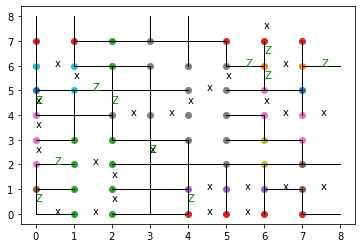

[1. 1.]


In [5]:
l = 2
r1 = 8
r2 = r1

# star stabilzers
Sx = np.zeros((r1*r2,l*r1*r2),dtype=int)
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r1)*r1+i_x)+1] = 1

# # loss error
prob_l = 0.4 # loss error probability
percolate_x = True
percolate_y = True

while (percolate_x or percolate_y):
    error_loss = np.random.rand(l*r1*r2) 
    loss_inds = np.argwhere(error_loss < prob_l)[:,0]
    remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
    percolate_y, percolate_x = does_loss_percolate(loss_inds) 
    error_loss[loss_inds] = 1
    error_loss[remain_inds] = 0

    Sx_new = []
    inds_new = []
    Sx_old = np.copy(Sx)
    inds_old = list(range(r1*r2))
    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_ind = list(st_ind[:,0])
        ## possibly more efficient
        if loss_index%2 ==0:
            q2 = int(int(loss_index/2)/r1)*r1 + ((int(loss_index/2)%r1+1)%r1)
        else:
            q2 = ((int(int(loss_index/2)/r1)+1)%r2)*r1 + (int(loss_index/2)%r1)
        star_ops = np.array([int(loss_index/2),q2])
        st_ind2 = star_ops[np.argwhere(Sx_old[np.ix_(star_ops),loss_index]>0)]
        st_ind2 = list(np.sort(st_ind2[:,1]))
        if not np.array_equal(st_ind2,st_ind):
            print(st_ind,st_ind2)
            
        if len(st_ind)==2:
            inds_new.append(st_ind)
            Stot = np.zeros(l*r1*r2)
            for i_remove in st_ind:
                inds_old.remove(i_remove)
                Stot += Sx_old[i_remove,:]
            Sx_new.append(list(Stot%2)) 
            Sx_old[st_ind,:] = 0
        elif len(st_ind)==1:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
            inds_new[st_new_ind][:] += st_ind
            inds_old.remove(st_ind[0])
            Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
            Sx_old[st_ind,:] = 0
        else:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
            if len(st_new_ind)>1:
                st_new_ind = list(st_new_ind[:,0])
                inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                Stot = np.zeros(l*r1*r2)
                for i_remove in st_new_ind:
                    Stot += np.array(Sx_new)[i_remove,:]        
                Sx_new[st_new_ind[0]] = list(Stot%2)
                del inds_new[st_new_ind[1]]
                del Sx_new[st_new_ind[1]]
    Sx_new = np.array(Sx_new, dtype=int)

    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_new_ind = np.argwhere(Sx_new[:,loss_index]>0)
        assert len(st_ind)+len(st_new_ind)==0

    color = 1
    plt.figure(1)
    plt.cla()
    for s_plaq in inds_new:
        color += 1
        for latt_pos in s_plaq:
            plt.plot((latt_pos%r1),int(latt_pos/r1),"o",color="C%d" % (color))

    num_Sx_red = len(inds_new)+len(inds_old)
    Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
    # print(np.shape(Sx_red[0:len(inds_old),:]),np.shape(Sx_old[np.ix_(inds_old,remain_inds)]))
    Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
    if len(inds_new)>0:
        Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

    keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
    Sx_red = Sx_red[:,keep_cols]

    qubits_to_plot = remain_inds[keep_cols]
    lost_qubits = np.array(list(set(np.arange(l*r1*r2)) - set(qubits_to_plot)))
    percolate_y, percolate_x = does_loss_percolate(lost_qubits)

plt.figure(1)
for i in range(len(qubits_to_plot)):
    latt_pos = int(qubits_to_plot[i]/2)
    if qubits_to_plot[i] % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) 
        plt.plot([rx,rx+1],[ry,ry],color="k",linewidth=1)
    else:
        ry = int(latt_pos/r1)  
        rx = (latt_pos%r1)   
        plt.plot([rx,rx],[ry,ry+1],color="k",linewidth=1)


num_qubits = len(qubits_to_plot)

overlap = Sx_red.T@Sx_red
inds_to_keep = list(range(np.size(Sx_red,1)))
nl = []
counter = 0
i = 0 
while counter < np.size(Sx_red,1):
    edge = inds_to_keep[i]
    ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
    if len(ovlp_inds)>0:
        # print("edge= ", edge)
        for j in ovlp_inds[::-1,0]:
            # print(inds_to_keep[i+1+j])
            inds_to_keep.remove(inds_to_keep[i+1+j])
        # print(inds_to_keep)
        counter += (len(ovlp_inds)+1)
        nl.append(len(ovlp_inds)+1)
    else:
        counter += 1
        nl.append(1)
    i += 1

Sx_red_netx = Sx_red[:,inds_to_keep]
remain_qubits = remain_inds[keep_cols[inds_to_keep]]
num_edge = len(remain_qubits) #np.size(Sx_red_netx,1)

nl = np.array(nl)
num_qubits = len(qubits_to_plot)

################# modified bit flip probabilities  ##############
prob_z = 0.1 # error probability
pl = (1-(1-2*prob_z)**nl)/2

########## weights on square lattice ############
weights = np.zeros(2*r1*r2)
weights[remain_qubits] = np.log((1-pl)/pl) 

inds_to_keep_2 = list(range(np.size(Sx_red,1)))
# counter = 0
# i = 0 
# while counter < np.size(Sx_red,1):
for i in range(num_edge):
    edge = inds_to_keep[i]
    ovlp_inds = np.argwhere(overlap[edge,inds_to_keep_2[i+1:]]==2)
    if len(ovlp_inds)>0:
        for j in ovlp_inds[::-1,0]:
            weights[qubits_to_plot[inds_to_keep_2[i+1+j]]] = np.log((1-pl[i])/pl[i]) 
    #     counter += (len(ovlp_inds)+1)
    # else:
    #     counter += 1
    # i += 1
    
# plt.figure(1)
# for i in range(2*r1*r2):
#     latt_pos = int(i/2)
#     if i % 2 == 0 :
#         ry = int(latt_pos/r1) 
#         rx = (latt_pos%r1) + 0.5   
#     else:
#         ry = int(latt_pos/r1)  + 0.5 #+0.1
#         rx = (latt_pos%r1)   

#     plt.text(rx,ry,"%d" % (weights[i]),color="k")

assert len(np.argwhere(weights>0))== num_qubits

###################################################
################# bit flip error  ##################
error_table = np.random.rand(num_edge) < pl
zflip_inds = np.argwhere(error_table == True)[:,0]
no_zflip_inds = np.argwhere(error_table == False)[:,0]
error_z = np.zeros(num_edge,dtype=int)
error_z[zflip_inds] = 1
# error_z[no_zflip_inds] = 0
error_z_orig = np.zeros(2*r1*r2,dtype=int)
error_z_orig[remain_qubits[zflip_inds]] = 1

plt.figure(1)
for i in range(len(zflip_inds)):
    latt_pos = int(remain_qubits[zflip_inds[i]]/2)
    if remain_qubits[zflip_inds[i]] % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) + 0.5   
    else:
        ry = int(latt_pos/r1)  + 0.5 #+0.1
        rx = (latt_pos%r1)   

    plt.text(rx,ry,"Z",color="g")

if num_edge > 1:
    # print("logical qubits: ", num_edge-2*Sx_red_netx.shape[0]+2)
    # m = Matching(Sx_red_netx,spacelike_weights=np.log((1-pl)/pl))
    m_orig = Matching(Sx,spacelike_weights=weights)

# find syndrome
syndrome_x = Sx_red_netx@error_z % 2
synd_x_inds = np.argwhere(syndrome_x > 0)
syndrome_x_orig = Sx@error_z_orig % 2
# print(synd_x_inds)
if len(synd_x_inds)>0:
    rec2_orig = m_orig.decode(syndrome_x_orig)
    rec2_orig_inds = np.argwhere(rec2_orig > 0)[:,0]
    # print(rec2_inds[:,0])
    plt.figure(1)
    for i in range(len(rec2_orig_inds)):
        latt_pos = int(rec2_orig_inds[i]/2)
        if rec2_orig_inds[i] % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) + 0.5   
        else:
            ry = int(latt_pos/r1)  + 0.5 #+0.1
            rx = (latt_pos%r1)   

        plt.text(rx,ry,"x",color="k")

#     # rec2 = m.decode(syndrome_x)
#     rec2 = np.zeros(num_edge,dtype=int)
#     for rec_q in rec2_orig_inds:
#         if rec_q in remain_qubits:
#             ind_q = np.argwhere(remain_qubits==rec_q)
#             rec2[ind_q]= 1
#     rec2_inds = np.argwhere(rec2 > 0)[:,0]
#     plt.figure(1)
#     for i in range(len(rec2_inds)):
#         latt_pos = int(remain_qubits[rec2_inds[i]]/2)
#         if remain_qubits[rec2_inds[i]] % 2 == 0 :
#             ry = int(latt_pos/r1) 
#             rx = (latt_pos%r1) + 0.5   
#         else:
#             ry = int(latt_pos/r1)  + 0.5 #+0.1
#             rx = (latt_pos%r1)   

#         plt.text(rx,ry,"o",color="r")

        
#################################
Gq_x = nx.Graph()
for qubit in qubits_to_plot:
    if qubit % 2 == 1:
        if (int(qubit/2)%r1)-1 >= 0:
            Gq_x.add_edge(int(qubit/2),int(qubit/2)-1)
    else:
        q2 = ((int(int(qubit/2)/r1)-1)%r2)*r1 + (int(qubit/2)%r1)
        Gq_x.add_edge(int(qubit/2),q2)

first_col = np.arange(0,(r2-1)*r1+1,r1)
last_col = np.arange(r1-1,r2*r1+1,r1)
path_x = False
for i_first in first_col:
    if i_first in Gq_x.nodes():
        for i_last in last_col:
            if i_last in Gq_x.nodes():
                if nx.has_path(Gq_x,i_first,i_last):
                    if int(i_first/r1) == int(i_last/r1) and (2*i_first+1 in qubits_to_plot):
#                                     print(i_first,i_last)
                        path_x = True
                        path_x_vals = nx.shortest_path(Gq_x,i_first,i_last)
#                                     print(path_x_vals)
                        break
    if path_x:
        break

logical_x = np.zeros(l*r1*r2)
logical_x[2*path_x_vals[0]+1] = 1
for i_v, v1 in enumerate(path_x_vals):
    if i_v < len(path_x_vals)-1:
        v2 = path_x_vals[i_v+1]
        if np.abs(v2-v1)==1:
            logical_x[2*max([v1,v2])+1] = 1
        elif np.abs(v2-v1)==r1:
            logical_x[2*max([v1,v2])] = 1
        else:
            logical_x[2*min([v1,v2])] = 1

# inds_logic_h = np.argwhere(logical_x[qubits_to_plot] > 0 )[:,0]
# for link in qubits_to_plot[inds_logic_h]:
#     latt_pos = int(link/2)
#     if link % 2 == 0 :
#         ry = int(latt_pos/r1) 
#         rx = (latt_pos%r1) + 0.5   
#     else:
#         ry = int(latt_pos/r1)  + 0.5 #+0.1
#         rx = (latt_pos%r1)   
#     plt.text(rx,ry,"o",color="g")

Gq_y = nx.Graph()
for qubit in qubits_to_plot:
    if qubit % 2 == 0:
        if int(qubit/2)-r1 >= 0:
            Gq_y.add_edge(int(qubit/2),int(qubit/2)-r1)
    else:
        q2 = int(int(qubit/2)/r1)*r1 + ((int(qubit/2)%r1-1)%r1)
        Gq_y.add_edge(int(qubit/2),q2)

first_row = np.arange(r1)
last_row = np.arange((r2-1)*r1,r2*r1)
path_y = False
for i_first in first_row:
    if i_first in Gq_y.nodes():
        for i_last in last_row:
            if i_last in Gq_y.nodes():
                if nx.has_path(Gq_y,i_first,i_last):
                    if (i_first - i_last )%r1 ==0 and (2*i_first in qubits_to_plot):
                        path_y = True
                        path_y_vals = nx.shortest_path(Gq_y,i_first,i_last)
                        break
    if path_y:
        break

logical_y = np.zeros(l*r1*r2)
logical_y[2*path_y_vals[0]] = 1
for i_v, v1 in enumerate(path_y_vals):
    if i_v < len(path_y_vals)-1:
        v2 = path_y_vals[i_v+1]
        if np.abs(v2-v1)==1:
            logical_y[2*max([v1,v2])+1] = 1
        elif np.abs(v2-v1)==r1:
            logical_y[2*max([v1,v2])] = 1
        else:
            logical_y[2*min([v1,v2])+1] = 1

# inds_logic_h = np.argwhere(logical_y[qubits_to_plot] > 0 )[:,0]
# for link in qubits_to_plot[inds_logic_h]:
#     latt_pos = int(link/2)
#     if link % 2 == 0 :
#         ry = int(latt_pos/r1) 
#         rx = (latt_pos%r1) + 0.5   
#     else:
#         ry = int(latt_pos/r1)  + 0.5 #+0.1
#         rx = (latt_pos%r1)   
#     plt.text(rx,ry,"v",color="b")
################

#################################
plt.xticks(np.arange(0,r1+1.))
plt.yticks(np.arange(0,r2+1.))
plt.show()

# error_rec = (rec2 + error_z )%2
# s1x = np.dot( error_rec , logical_x[remain_qubits].T) %2 
# s1y = np.dot( error_rec , logical_y[remain_qubits].T) %2 
# print(s1x,s1y)

logicals = np.zeros((2,2*r1*r2))
logicals[0,1:2*r2+1:2] = np.ones(r2) 
logicals[1,0:2*r1*r2:2*r2] = np.ones(r2) 
error_rec_orig = (rec2_orig + error_z_orig )%2
s_orig = np.dot( error_rec_orig , logicals.T) %2 
print(s_orig)


## anisotrpoy

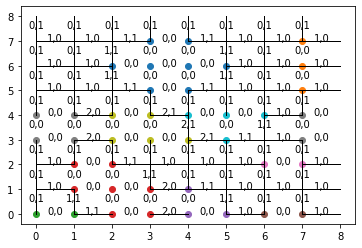

In [115]:
l = 2
r1 = 8
r2 = r1

# star stabilzers
Sx = np.zeros((r1*r2,l*r1*r2),dtype=int)
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r1)*r1+i_x)+1] = 1

# # loss error
prob_l = 0.3 # loss error probability
percolate_x = True
percolate_y = True

while (percolate_x or percolate_y):
    error_loss = np.random.rand(l*r1*r2) 
    loss_inds = np.argwhere(error_loss < prob_l)[:,0]
    remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
    percolate_y, percolate_x = does_loss_percolate(loss_inds) 
    error_loss[loss_inds] = 1
    error_loss[remain_inds] = 0

    Sx_new = []
    inds_new = []
    Sx_old = np.copy(Sx)
    inds_old = list(range(r1*r2))
    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_ind = list(st_ind[:,0])
        ## possibly more efficient
        if loss_index%2 ==0:
            q2 = int(int(loss_index/2)/r1)*r1 + ((int(loss_index/2)%r1+1)%r1)
        else:
            q2 = ((int(int(loss_index/2)/r1)+1)%r2)*r1 + (int(loss_index/2)%r1)
        star_ops = np.array([int(loss_index/2),q2])
        st_ind2 = star_ops[np.argwhere(Sx_old[np.ix_(star_ops),loss_index]>0)]
        st_ind2 = list(np.sort(st_ind2[:,1]))
        if not np.array_equal(st_ind2,st_ind):
            print(st_ind,st_ind2)
            
        if len(st_ind)==2:
            inds_new.append(st_ind)
            Stot = np.zeros(l*r1*r2)
            for i_remove in st_ind:
                inds_old.remove(i_remove)
                Stot += Sx_old[i_remove,:]
            Sx_new.append(list(Stot%2)) 
            Sx_old[st_ind,:] = 0
        elif len(st_ind)==1:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
            inds_new[st_new_ind][:] += st_ind
            inds_old.remove(st_ind[0])
            Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
            Sx_old[st_ind,:] = 0
        else:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
            if len(st_new_ind)>1:
                st_new_ind = list(st_new_ind[:,0])
                inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                Stot = np.zeros(l*r1*r2)
                for i_remove in st_new_ind:
                    Stot += np.array(Sx_new)[i_remove,:]        
                Sx_new[st_new_ind[0]] = list(Stot%2)
                del inds_new[st_new_ind[1]]
                del Sx_new[st_new_ind[1]]
    Sx_new = np.array(Sx_new, dtype=int)

    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_new_ind = np.argwhere(Sx_new[:,loss_index]>0)
        assert len(st_ind)+len(st_new_ind)==0

    color = 1
    plt.figure(1)
    plt.cla()
    for s_plaq in inds_new:
        color += 1
        for latt_pos in s_plaq:
            plt.plot((latt_pos%r1),int(latt_pos/r1),"o",color="C%d" % (color))

    num_Sx_red = len(inds_new)+len(inds_old)
    Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
    # print(np.shape(Sx_red[0:len(inds_old),:]),np.shape(Sx_old[np.ix_(inds_old,remain_inds)]))
    Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
    if len(inds_new)>0:
        Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

    keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
    Sx_red = Sx_red[:,keep_cols]

    qubits_to_plot = remain_inds[keep_cols]
    lost_qubits = np.array(list(set(np.arange(l*r1*r2)) - set(qubits_to_plot)))
    percolate_y, percolate_x = does_loss_percolate(lost_qubits)

plt.figure(1)
for i in range(len(qubits_to_plot)):
    latt_pos = int(qubits_to_plot[i]/2)
    if qubits_to_plot[i] % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) 
        plt.plot([rx,rx+1],[ry,ry],color="k",linewidth=1)
    else:
        ry = int(latt_pos/r1)  
        rx = (latt_pos%r1)   
        plt.plot([rx,rx],[ry,ry+1],color="k",linewidth=1)


num_qubits = len(qubits_to_plot)

overlap = Sx_red.T@Sx_red

# print(overlap)
# print(overlap2)

inds_to_keep = list(range(np.size(Sx_red,1)))
ql = []
nl = []
nl_x = []
nl_y = []
counter = 0
i = 0 
while counter < np.size(Sx_red,1):
    edge = inds_to_keep[i]
    ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
    if qubits_to_plot[edge] %l ==0:
        nl_i_x = 1
        nl_i_y = 0 
    else:
        nl_i_x = 0 
        nl_i_y = 1
    nl_i = len(ovlp_inds)+1

    if len(ovlp_inds)>0:
        qlist = qubits_to_plot[np.ix_([ inds_to_keep[k] for k in i+1+ovlp_inds[:,0]])]
        ovlp_inds_x = np.argwhere(qlist %l==0)
        ovlp_inds_y = np.argwhere(qlist %l >0)
        nl_i_x += len(ovlp_inds_x)
        nl_i_y += len(ovlp_inds_y)
        for j in ovlp_inds[::-1,0]:
            inds_to_keep.remove(inds_to_keep[i+1+j])
        ql.append(np.concatenate(([qubits_to_plot[edge]],qlist)))
    else:
        ql.append([qubits_to_plot[edge]])

    counter += nl_i
    nl.append(nl_i)
    nl_x.append(nl_i_x)
    nl_y.append(nl_i_y)
    i += 1
    


Sx_red_netx = Sx_red[:,inds_to_keep]
remain_qubits = remain_inds[keep_cols[inds_to_keep]]
num_edge = len(remain_qubits) #np.size(Sx_red_netx,1)

nl = np.array(nl)
nl_x = np.array(nl_x)
nl_y = np.array(nl_y)
num_qubits = len(qubits_to_plot)

################# modified bit flip probabilities  ##############
prob_z = 0.1 # error probability
prob_x = 0.1
prob_y = 0.2
# pl = (1-(1-2*prob_z)**nl)/2
pl = (1-(1-2*prob_x)**nl_x * (1-2*prob_y)**nl_y)/2
# ########## weights on square lattice ############
weights2 = np.zeros((2*r1*r2,2))
weights2[remain_qubits,0] = nl_x #np.log((1-pl)/pl) 
weights2[remain_qubits,1] = nl_y #np.log((1-pl)/pl) 

weights = np.zeros(2*r1*r2)
weights[remain_qubits] = np.log((1-pl)/pl) 

inds_to_keep_2 = list(range(np.size(Sx_red,1)))

for i in range(num_edge):
    edge = inds_to_keep[i]
    ovlp_inds = np.argwhere(overlap[edge,inds_to_keep_2[i+1:]]==2)
    if len(ovlp_inds)>0:
        for j in ovlp_inds[::-1,0]:
            weights[qubits_to_plot[inds_to_keep_2[i+1+j]]] = weights[qubits_to_plot[edge]]#np.log((1-pl[i])/pl[i]) 
            weights2[qubits_to_plot[inds_to_keep_2[i+1+j]],:] = weights2[qubits_to_plot[edge],:]#np.log((1-pl[i])/pl[i]) 

    
plt.figure(1)
for i in range(2*r1*r2):
    latt_pos = int(i/2)
    if i % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) + 0.3
    else:
        ry = int(latt_pos/r1)  + 0.5 #+0.1
        rx = (latt_pos%r1) - 0.2 

    # plt.text(rx,ry,"%d" % (weights[i]),color="k")
    plt.text(rx,ry,"%d,%d" % (weights2[i,0],weights2[i,1]),color="k")


assert len(np.argwhere(weights>0))== num_qubits

#################################
plt.xticks(np.arange(0,r1+1.))
plt.yticks(np.arange(0,r2+1.))
plt.show()


[ 1  2  3  4  9 11 18 19 25 42 43 50 54 56 57 58 59 61 62 63 65 66 67 68
 69]


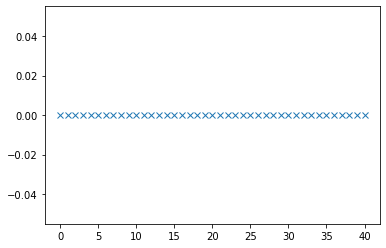

In [120]:
overlap = Sx_red.T@Sx_red
inds = np.argwhere(overlap>1)
# print(inds)
rep_edges = []
inds_red = []
for i_v in inds:
    if i_v[1]>i_v[0]:
        # inds_red.append(i_v)
        if not (i_v[0] in rep_edges):
            rep_edges.append(i_v[0])
        if not (i_v[1] in rep_edges):
            rep_edges.append(i_v[1])
# print(qubits_to_plot[rep_edges])
# print(rep_edges)

rep_edges = np.sort(rep_edges)
not_rep_qubits = np.array(list(set(range(np.size(Sx_red,1))) - set(rep_edges)))
print(not_rep_qubits)

inds_red = np.array(inds_red)
# print(inds_red)

# # overlap = Sx_red[verts,:].T@Sx_red[verts,:]
# # print(overlap)
# nl2 = []
# inds_to_keep2 = []
# for ind_q, i_q in enumerate(rep_edges):
#     # rep_inds = np.argwhere(inds_red[:,0]==i_q)[:,0]
#     rep_inds = np.argwhere(overlap[i_q,rep_edges[ind_q+1:]]==2)[:,0]
#     print(ind_q+1+rep_inds)
#     if len(rep_inds)>0:
#         inds_to_keep2.append(i_q)
#         nl2.append(1+len(rep_inds))
#     # print(i_q,rep_inds)
# # print(nl)
# print(rep_edges)
# # inds_to_keep2 = np.sort(np.concatenate((inds_to_keep2,not_rep_qubits)))
# # print(inds_to_keep)
# # print(inds_to_keep2)

ql2 = []
nl2 = []
nl_x2 = []
nl_y2 = []
counter = 0
i = 0 
overlap2 = overlap[np.ix_(rep_edges,rep_edges)]
inds_to_keep2 = list(range(len(rep_edges)))
while counter < len(rep_edges):
    edge = inds_to_keep2[i]
    ovlp_inds = np.argwhere(overlap2[edge,inds_to_keep2[i+1:]]==2)
    if qubits_to_plot[rep_edges[edge]] %l ==0:
        nl_i_x = 1
        nl_i_y = 0 
    else:
        nl_i_x = 0 
        nl_i_y = 1
    nl_i = len(ovlp_inds)+1

    qlist = qubits_to_plot[rep_edges[np.ix_([ inds_to_keep2[k] for k in i+1+ovlp_inds[:,0]])]]
    ovlp_inds_x = np.argwhere(qlist %l==0)
    ovlp_inds_y = np.argwhere(qlist %l >0)
    nl_i_x += len(ovlp_inds_x)
    nl_i_y += len(ovlp_inds_y)
    for j in ovlp_inds[::-1,0]:
        inds_to_keep2.remove(inds_to_keep2[i+1+j])
    ql2.append(np.concatenate(([qubits_to_plot[rep_edges[edge]]],qlist)))
    counter += nl_i
    nl2.append(nl_i)
    nl_x2.append(nl_i_x)
    nl_y2.append(nl_i_y)
    i += 1

nl_x_tot = np.zeros(len(inds_to_keep2)+len(not_rep_qubits))
nl_x_tot[ np.argwhere(qubits_to_plot[not_rep_qubits]%l ==0)  ] = 1 
nl_x_tot[len(not_rep_qubits):] = nl_x2

nl_y_tot = np.zeros(len(inds_to_keep2)+len(not_rep_qubits))
nl_y_tot[ np.argwhere(qubits_to_plot[not_rep_qubits]%l >0)  ] = 1 
nl_y_tot[len(not_rep_qubits):] = nl_y2

nl_tot = np.concatenate((np.ones(len(not_rep_qubits)),nl2))
ql_tot = []
for i in range(len(nl_tot)):
    ql_tot.append(not_rep_qubits[i])

inds_to_keep2 = rep_edges[inds_to_keep2]
comb_inds = np.concatenate((not_rep_qubits,inds_to_keep2))
inds_sorted = np.argsort(comb_inds)
inds_to_keep2 = comb_inds[inds_sorted]
nl_x_tot = nl_x_tot[inds_sorted]
nl_y_tot = nl_y_tot[inds_sorted]
nl_tot = nl_tot[inds_sorted]

# plt.plot(inds_to_keep,"o")
plt.plot(inds_to_keep2-inds_to_keep,"x")

In [124]:
print(ql)

[array([  0, 115]), [1], [3], [4], [5], array([  6,   9,  24,  40,  56,  72, 104, 105]), array([10, 26, 42]), array([12, 15]), [14], [18], array([20, 21]), array([30, 33, 46]), [34], [35], array([45, 60]), array([48, 51]), [50], array([58, 74]), array([63, 78, 94]), array([66, 69, 84, 85, 98]), array([75, 91]), array([76, 77]), array([81, 96, 99]), [88], [90], array([ 93, 108]), [101], array([103, 119]), [106], [109], [110], [111], [114], [116], [117], [118], [122], [124], [125], [126], [127]]


In [99]:
a = np.array([0,4,1,2])
i = np.argsort(a)
print(i,a[i])

[0 2 3 1] [0 1 2 4]


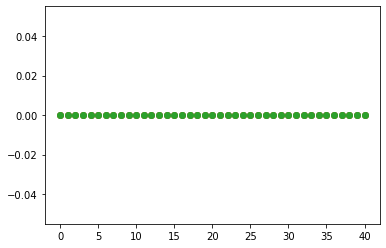

In [121]:
plt.plot(nl_x-nl_x_tot,"o")
plt.plot(nl_y-nl_y_tot,"o")
plt.plot(nl-nl_tot,"o")
# plt.plot(weights-np.sum(weights2,axis=1))
# plt.plot(nl_x,".")
# plt.plot(nl_y,".")
plt.show()

In [165]:
# checking probabilities

import math

px = np.random.rand()*0.01
py = np.random.rand()*0.1
nl_x = 1
nl_y = 2
pe = 0
for ix in range(nl_x+1):
    for iy in range(nl_y+1):
        if (ix+iy)%2==1:
            pe += math.comb(nl_x,ix)* (px**ix) * (1-px)**(nl_x-ix) * math.comb(nl_y,iy)* (py**iy) * (1-py)**(nl_y-iy) 
        
print(pe)
print((1-(1-2*px)**nl_x * (1-2*py)**nl_y)/2)

0.1461999488093934
0.14619994880939347


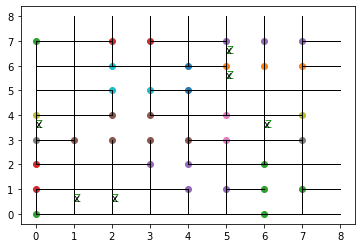

[0. 0.]


In [153]:
## final code

l = 2
r1 = 8
r2 = r1

# star stabilzers
Sx = np.zeros((r1*r2,l*r1*r2),dtype=int)
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r1)*r1+i_x)+1] = 1

# # loss error
prob_l = 0.2 # loss error probability
percolate_x = True
percolate_y = True

while (percolate_x or percolate_y):
    error_loss = np.random.rand(l*r1*r2) 
    loss_inds = np.argwhere(error_loss < prob_l)[:,0]
    remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
    percolate_y, percolate_x = does_loss_percolate(loss_inds) 
    error_loss[loss_inds] = 1
    error_loss[remain_inds] = 0

    Sx_new = []
    inds_new = []
    Sx_old = np.copy(Sx)
    inds_old = list(range(r1*r2))
    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_ind = list(st_ind[:,0])
        ## possibly more efficient
        if loss_index%2 ==0:
            q2 = int(int(loss_index/2)/r1)*r1 + ((int(loss_index/2)%r1+1)%r1)
        else:
            q2 = ((int(int(loss_index/2)/r1)+1)%r2)*r1 + (int(loss_index/2)%r1)
        star_ops = np.array([int(loss_index/2),q2])
        st_ind2 = star_ops[np.argwhere(Sx_old[np.ix_(star_ops),loss_index]>0)]
        st_ind2 = list(np.sort(st_ind2[:,1]))
        if not np.array_equal(st_ind2,st_ind):
            print(st_ind,st_ind2)
            
        if len(st_ind)==2:
            inds_new.append(st_ind)
            Stot = np.zeros(l*r1*r2)
            for i_remove in st_ind:
                inds_old.remove(i_remove)
                Stot += Sx_old[i_remove,:]
            Sx_new.append(list(Stot%2)) 
            Sx_old[st_ind,:] = 0
        elif len(st_ind)==1:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
            inds_new[st_new_ind][:] += st_ind
            inds_old.remove(st_ind[0])
            Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
            Sx_old[st_ind,:] = 0
        else:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
            if len(st_new_ind)>1:
                st_new_ind = list(st_new_ind[:,0])
                inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                Stot = np.zeros(l*r1*r2)
                for i_remove in st_new_ind:
                    Stot += np.array(Sx_new)[i_remove,:]        
                Sx_new[st_new_ind[0]] = list(Stot%2)
                del inds_new[st_new_ind[1]]
                del Sx_new[st_new_ind[1]]
    Sx_new = np.array(Sx_new, dtype=int)

    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_new_ind = np.argwhere(Sx_new[:,loss_index]>0)
        assert len(st_ind)+len(st_new_ind)==0

    color = 1
    plt.figure(1)
    plt.cla()
    for s_plaq in inds_new:
        color += 1
        for latt_pos in s_plaq:
            plt.plot((latt_pos%r1),int(latt_pos/r1),"o",color="C%d" % (color))

    num_Sx_red = len(inds_new)+len(inds_old)
    Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
    # print(np.shape(Sx_red[0:len(inds_old),:]),np.shape(Sx_old[np.ix_(inds_old,remain_inds)]))
    Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
    if len(inds_new)>0:
        Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

    keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
    Sx_red = Sx_red[:,keep_cols]

    qubits_to_plot = remain_inds[keep_cols]
    lost_qubits = np.array(list(set(np.arange(l*r1*r2)) - set(qubits_to_plot)))
    percolate_y, percolate_x = does_loss_percolate(lost_qubits)

plt.figure(1)
for i in range(len(qubits_to_plot)):
    latt_pos = int(qubits_to_plot[i]/2)
    if qubits_to_plot[i] % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) 
        plt.plot([rx,rx+1],[ry,ry],color="k",linewidth=1)
    else:
        ry = int(latt_pos/r1)  
        rx = (latt_pos%r1)   
        plt.plot([rx,rx],[ry,ry+1],color="k",linewidth=1)


num_qubits = len(qubits_to_plot)

overlap = Sx_red.T@Sx_red
inds_to_keep = list(range(np.size(Sx_red,1)))
ql = []
nl = []
nl_x = []
nl_y = []
counter = 0
i = 0 
while counter < np.size(Sx_red,1):
    edge = inds_to_keep[i]
    ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
    if qubits_to_plot[edge] %l ==0:
        nl_i_x = 1
        nl_i_y = 0 
    else:
        nl_i_x = 0 
        nl_i_y = 1
    nl_i = len(ovlp_inds)+1

    if len(ovlp_inds)>0:
        qlist = qubits_to_plot[np.ix_([ inds_to_keep[k] for k in i+1+ovlp_inds[:,0]])]
        ovlp_inds_x = np.argwhere(qlist %l==0)
        ovlp_inds_y = np.argwhere(qlist %l >0)
        nl_i_x += len(ovlp_inds_x)
        nl_i_y += len(ovlp_inds_y)
        for j in ovlp_inds[::-1,0]:
            inds_to_keep.remove(inds_to_keep[i+1+j])
        ql.append(np.concatenate(([qubits_to_plot[edge]],qlist)))
    else:
        ql.append([qubits_to_plot[edge]])

    counter += nl_i
    nl.append(nl_i)
    nl_x.append(nl_i_x)
    nl_y.append(nl_i_y)
    i += 1


Sx_red_netx = Sx_red[:,inds_to_keep]
remain_qubits = remain_inds[keep_cols[inds_to_keep]]
num_edge = len(remain_qubits) #np.size(Sx_red_netx,1)

nl = np.array(nl)
nl_x = np.array(nl_x)
nl_y = np.array(nl_y)
num_qubits = len(qubits_to_plot)

################# modified bit flip probabilities  ##############
prob_x = 0.01
prob_y = 0.2
pl = (1-(1-2*prob_x)**nl_x * (1-2*prob_y)**nl_y)/2
# ########## weights on square lattice ############
weights = np.zeros(2*r1*r2)
weights[remain_qubits] = np.log((1-pl)/pl) 

inds_to_keep_2 = list(range(np.size(Sx_red,1)))
for i in range(num_edge):
    edge = inds_to_keep[i]
    ovlp_inds = np.argwhere(overlap[edge,inds_to_keep_2[i+1:]]==2)
    if len(ovlp_inds)>0:
        for j in ovlp_inds[::-1,0]:
            weights[qubits_to_plot[inds_to_keep_2[i+1+j]]] = weights[qubits_to_plot[edge]]#np.log((1-pl[i])/pl[i]) 

assert len(np.argwhere(weights>0))== num_qubits

###################################################
################# bit flip error  ##################
error_table = np.random.rand(num_edge) < pl
zflip_inds = np.argwhere(error_table == True)[:,0]
no_zflip_inds = np.argwhere(error_table == False)[:,0]
error_z = np.zeros(num_edge,dtype=int)
error_z[zflip_inds] = 1
# error_z[no_zflip_inds] = 0
error_z_orig = np.zeros(2*r1*r2,dtype=int)
error_z_orig[remain_qubits[zflip_inds]] = 1

plt.figure(1)
for i in range(len(zflip_inds)):
    latt_pos = int(remain_qubits[zflip_inds[i]]/2)
    if remain_qubits[zflip_inds[i]] % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) + 0.5   
    else:
        ry = int(latt_pos/r1)  + 0.5 #+0.1
        rx = (latt_pos%r1)   

    plt.text(rx,ry,"Z",color="g")

if num_edge > 1:
    # print("logical qubits: ", num_edge-2*Sx_red_netx.shape[0]+2)
    # m = Matching(Sx_red_netx,spacelike_weights=np.log((1-pl)/pl))
    m_orig = Matching(Sx,spacelike_weights=weights)

# find syndrome
syndrome_x = Sx_red_netx@error_z % 2
synd_x_inds = np.argwhere(syndrome_x > 0)
syndrome_x_orig = Sx@error_z_orig % 2
# print(synd_x_inds)
if len(synd_x_inds)>0:
    rec2_orig = m_orig.decode(syndrome_x_orig)
    rec2_orig_inds = np.argwhere(rec2_orig > 0)[:,0]
    # print(rec2_inds[:,0])
    plt.figure(1)
    for i in range(len(rec2_orig_inds)):
        latt_pos = int(rec2_orig_inds[i]/2)
        if rec2_orig_inds[i] % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) + 0.5   
        else:
            ry = int(latt_pos/r1)  + 0.5 #+0.1
            rx = (latt_pos%r1)   

        plt.text(rx,ry,"x",color="k")

#################################
plt.xticks(np.arange(0,r1+1.))
plt.yticks(np.arange(0,r2+1.))
plt.show()

# for i_l in range(len(ql)):
#     print(ql[i_l])

# for i_q, qubits in enumerate(ql):
#     print(qubits)
# print("qubits")

logicals = np.zeros((2,2*r1*r2))
logicals[0,1:2*r2+1:2] = np.ones(r2) 
logicals[1,0:2*r1*r2:2*r2] = np.ones(r2) 
error_rec_orig = (rec2_orig + error_z_orig )%2
s_orig = np.dot( error_rec_orig , logicals.T) %2 
print(s_orig)

## efficient code for effective Sx

In [154]:
G_loss = nx.Graph()

for qubit in loss_inds:
    if qubit % 2 == 0:
        q2 = int(int(qubit/2)/r1)*r1 + ( (int(qubit/2)%r1) +1)%r1
        G_loss.add_edge(int(qubit/2),q2)
    else:
        q2 = ((int(int(qubit/2)/r1)+1)%r2)*r1 + (int(qubit/2)%r1)
        G_loss.add_edge(int(qubit/2),q2)

# nx.draw(G_loss, with_labels=True, font_weight='bold')
# plt.show()
components = [G_loss.subgraph(c).copy() for c in nx.connected_components(G_loss)]
lost_vs = []
for i_c, c in enumerate(components):
    lost_vs += c.nodes()
    
remain_vs = list(set(range(r1*r2)) - set(lost_vs))
num_stab = len(components)+len(remain_vs)
Sx_red2 = np.zeros((num_stab,len(remain_inds)))
Sx_red2[len(components):,:] = Sx[np.ix_(remain_vs,remain_inds)]
for i_c, c in enumerate(components):
    Sx_red2[i_c,:] = np.sum(Sx[np.ix_(c.nodes(),remain_inds)],axis = 0)%2

keep_cols = np.argwhere(np.sum(Sx_red2,axis=0)>0)[:,0]
Sx_red2 = Sx_red2[:,keep_cols]

overlap2 = Sx_red2.T@Sx_red2

assert np.sum(np.sum(np.abs(overlap2-overlap))) == 0